<a href="https://colab.research.google.com/github/Viktoria574/ML/blob/main/TIMO_pract7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('bank_data.csv')
data.head()

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [ ]:
print('Размер данных', data.shape)
print(data.columns)

Размер данных (4521, 18)
Index(['Unnamed: 0', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')


In [ ]:
# Удаление повторяющихся строк
data = data.drop_duplicates()

# Удаляем строки с значением 'unknown'
data = data.replace('unknown', pd.NA).dropna()

# Переводим категориальные столбцы 'yes' и 'no' в числовые значения 1 и 0
data['default'] = data['default'].map({'yes': 1, 'no': 0})
data['housing'] = data['housing'].map({'yes': 1, 'no': 0})
data['loan'] = data['loan'].map({'yes': 1, 'no': 0})
data['y'] = data['y'].map({'yes': 1, 'no': 0})
data = data.drop(columns=['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'Unnamed: 0'])

print("Размерность датасета: ",data.shape)
data.head()

Размерность датасета:  (764, 11)


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
1,33,0,4789,1,1,11,220,1,339,4,0
2,35,0,1350,1,0,16,185,1,330,1,0
5,35,0,747,0,0,23,141,2,176,3,0
6,36,0,307,1,0,14,341,1,330,2,0
9,43,0,-88,1,1,17,313,1,147,2,0


In [ ]:
# Определение целевого столбца
X = data.drop(columns = 'y', axis = 1)
y = data['y']

scaler =  StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

coefficients = model.coef_

r_squared = model.score(X_test, y_test)

print("R² модели:", r_squared)

R² модели: 0.7777777777777778


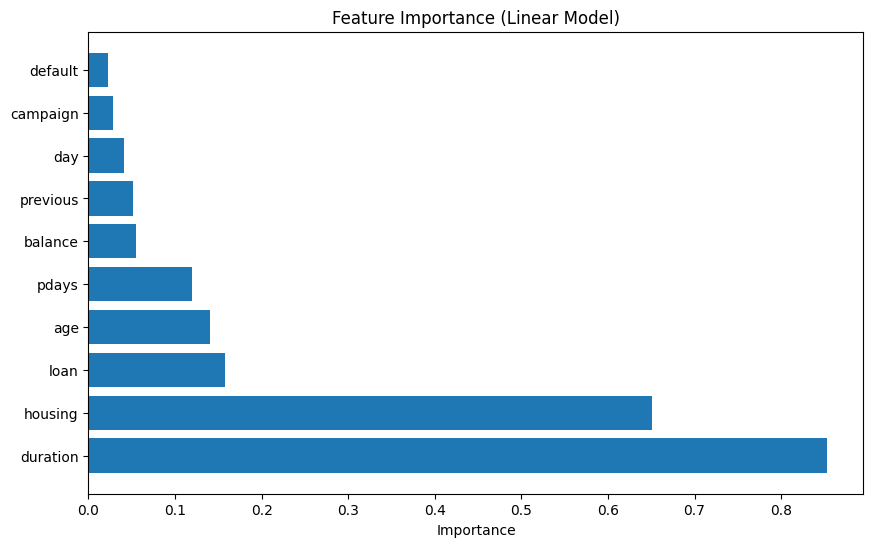

In [ ]:
coefficients = model.coef_[0]  # Извлекаем коэффициенты первой строки (для бинарной классификации)
feature_names = X.columns      # Имена признаков из DataFrame X

# Вычисление важности
importance = np.abs(coefficients)
sorted_indices = np.argsort(importance)[::-1]  # Индексы в порядке убывания важности

# Сортировка признаков по важности
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance = importance[sorted_indices]

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance)
plt.xlabel('Importance')
plt.title('Feature Importance (Linear Model)')
plt.show()

In [ ]:
# Создание селектора для выбора 5 лучших признаков
selector = SequentialFeatureSelector(LogisticRegression(max_iter=10000), n_features_to_select=5)
selector.fit(X_train, y_train)

# Извлечение имен выбранных признаков
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features.tolist())

Selected features: ['age', 'default', 'balance', 'day', 'duration']


In [ ]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

print("Lasso coefs:", lasso_model.coef_)
print(f'Not null coefs amount: {sum(lasso_model.coef_ != 0)}')

Lasso coefs: [ 0.         -0.          0.         -0.00540524 -0.          0.
  0.04359484 -0.         -0.          0.        ]
Not null coefs amount: 2


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Accuracy (Random Forest):", accuracy_score(y_test, y_pred_rf))

gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print("Accuracy (Gradient Boosting):", accuracy_score(y_test, y_pred_gb))

Accuracy (Random Forest): 0.7647058823529411
Accuracy (Gradient Boosting): 0.7973856209150327


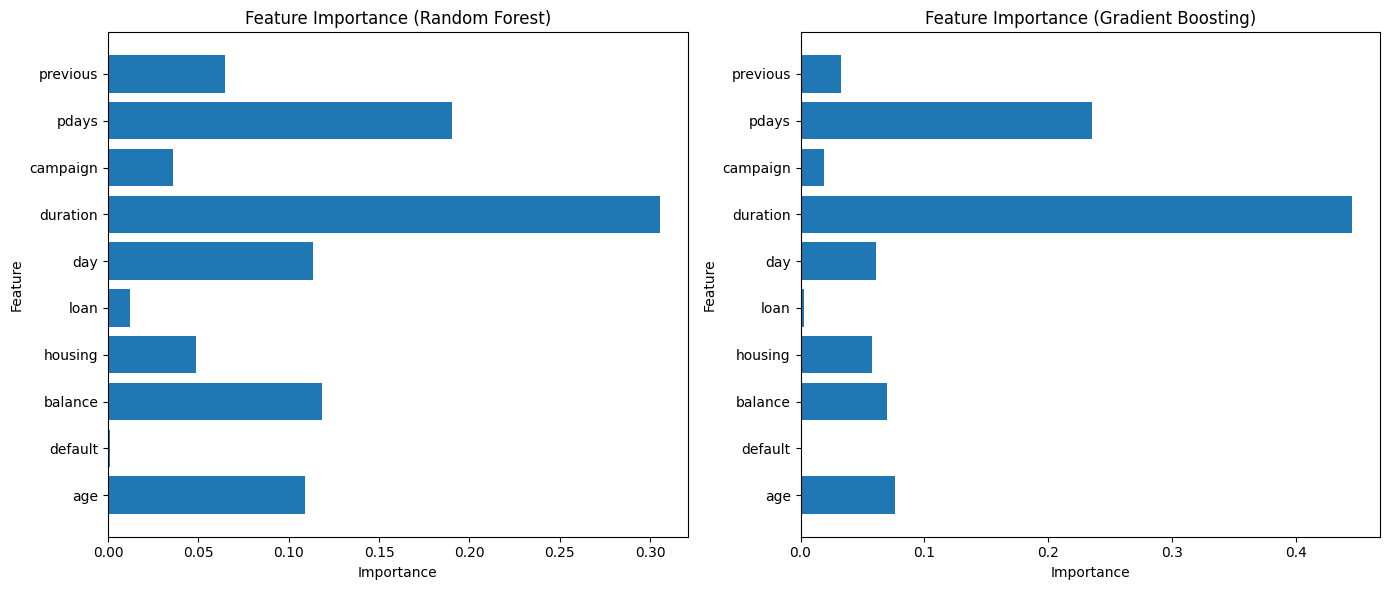

In [ ]:
rf_importance = rf_model.feature_importances_

gb_importance = gb_model.feature_importances_

feature_names = data.drop("y", axis=1).columns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].barh(feature_names, rf_importance)
ax[0].set_title("Feature Importance (Random Forest)")
ax[0].set_xlabel("Importance")
ax[0].set_ylabel("Feature")

ax[1].barh(feature_names, gb_importance)
ax[1].set_title("Feature Importance (Gradient Boosting)")
ax[1].set_xlabel("Importance")
ax[1].set_ylabel("Feature")


plt.tight_layout()

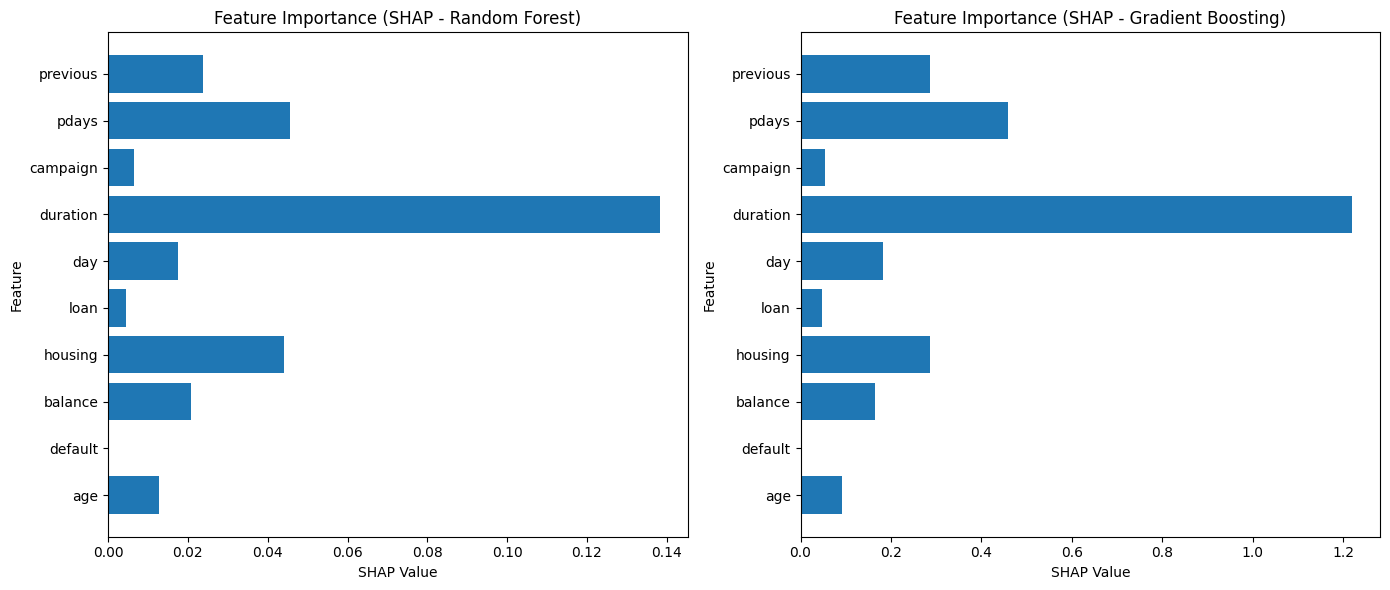

In [ ]:
explainer_rf = shap.TreeExplainer(rf_model)
explainer_gb = shap.TreeExplainer(gb_model)

shap_values_rf = explainer_rf.shap_values(X_test)
shap_values_gb = explainer_gb.shap_values(X_test)

mean_abs_shap_values_rf = np.abs(shap_values_rf[:,:,0]).mean(axis=0)
mean_abs_shap_values_gb = np.abs(shap_values_gb).mean(axis=0)

feature_names = data.drop("y", axis=1).columns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].barh(feature_names, mean_abs_shap_values_rf)
ax[0].set_title("Feature Importance (SHAP - Random Forest)")
ax[0].set_xlabel("SHAP Value")
ax[0].set_ylabel("Feature")

ax[1].barh(feature_names, mean_abs_shap_values_gb)
ax[1].set_title("Feature Importance (SHAP - Gradient Boosting)")
ax[1].set_xlabel("SHAP Value")
ax[1].set_ylabel("Feature")

plt.tight_layout()

In [ ]:
rf_importances = rf_model.feature_importances_

top_10_rf_indices = np.argsort(rf_importances)[-10:]

X_train_top10_rf = X_train[:, top_10_rf_indices]
X_test_top10_rf = X_test[:, top_10_rf_indices]

rf_top10 = RandomForestClassifier(n_estimators=100)
rf_top10.fit(X_train_top10_rf, y_train)

y_pred_rf_top10 = rf_top10.predict(X_test_top10_rf)
accuracy_rf_top10 = accuracy_score(y_test, y_pred_rf_top10)

gb_importances = gb_model.feature_importances_

top_10_gb_indices = np.argsort(gb_importances)[-10:]

X_train_top10_gb = X_train[:, top_10_gb_indices]
X_test_top10_gb = X_test[:, top_10_gb_indices]

gb_top10 = GradientBoostingClassifier(n_estimators=100)
gb_top10.fit(X_train_top10_gb, y_train)

y_pred_gb_top10 = gb_top10.predict(X_test_top10_gb)
accuracy_gb_top10 = accuracy_score(y_test, y_pred_gb_top10)

y_pred_rf_all = rf_model.predict(X_test)
accuracy_rf_all = accuracy_score(y_test, y_pred_rf_all)

y_pred_gb_all = gb_model.predict(X_test)
accuracy_gb_all = accuracy_score(y_test, y_pred_gb_all)

print(f"Accuracy Random Forest (all features): {accuracy_rf_all:.4f}")
print(f"Accuracy Random Forest (top 10 features): {accuracy_rf_top10:.4f}")
print(f"Accuracy Gradient Boosting (all features): {accuracy_gb_all:.4f}")
print(f"Accuracy Gradient Boosting (top 10 features): {accuracy_gb_top10:.4f}")

Accuracy Random Forest (all features): 0.7647
Accuracy Random Forest (top 10 features): 0.7582
Accuracy Gradient Boosting (all features): 0.7974
Accuracy Gradient Boosting (top 10 features): 0.7974


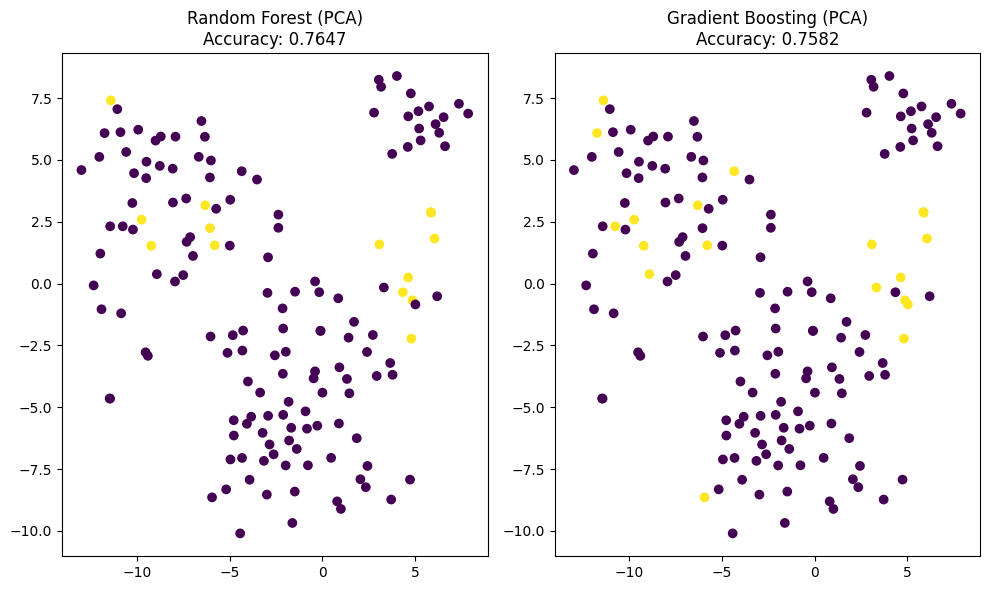

In [ ]:
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf_pca = RandomForestClassifier(n_estimators=100)
rf_pca.fit(X_train_pca, y_train)

gb_pca = GradientBoostingClassifier(n_estimators=100)
gb_pca.fit(X_train_pca, y_train)

y_pred_rf_pca = rf_pca.predict(X_test_pca)
accuracy_rf_pca = accuracy_score(y_test, y_pred_rf_pca)

y_pred_gb_pca = gb_pca.predict(X_test_pca)
accuracy_gb_pca = accuracy_score(y_test, y_pred_gb_pca)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_test)

plt.figure(figsize=(10, 6))

plt.subplot(121)
scatter_rf = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred_rf_pca)
plt.title(f"Random Forest (PCA)\nAccuracy: {accuracy_rf_pca:.4f}")

plt.subplot(122)
scatter_gb = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred_gb_pca)
plt.title(f"Gradient Boosting (PCA)\nAccuracy: {accuracy_gb_pca:.4f}")

plt.tight_layout()